# TASK 1: Initial data loading and clearning in python and Data importing in PostgreSQL server 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

In [3]:
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
from shapely.wkt import loads
import geopandas as gpd

### The below two functions are used to connect the python with PostgreSQL so that we can access database in SQL server.

In [8]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [9]:
db, conn = pgconnect(credentials)

Connected successfully.


In [10]:
conn.execute(text("""CREATE EXTENSION IF NOT EXISTS postgis;"""))

In [11]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.4 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


# The below is the SA2 dataset

The xml file storing the metadata is loaded to have a look.

In [8]:
with open('SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.xml', 'r') as f_SA2:
    data_SA2 = f_SA2.read()
SA2_data = BeautifulSoup(data_SA2, "lxml")
SA2_data

<?xml version="1.0" encoding="UTF-8"?><!-- edited with XMLSpy v2020 rel. 2 sp1 (x64) (http://www.altova.com) by  (Australian Bureau of Statistics) --><!-- UNCLASSIFIED --><!-- Built from ANZLIC MET Template ISO 19139 2009-02-18 --><html><body><gmd:md_metadata xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:gml="http://www.opengis.net/gml" xmlns:gts="http://www.isotc211.org/2005/gts" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.isotc211.org/2005/gmd http://www.isotc211.org/2005/gmd/gmd.xsd http://www.opengis.net/gml http://www.isotc211.org/2005/gml/gml.xsd http://www.w3.org/1999/xlink http://www.isotc211.org/2005/xlink/xlinks.xsd">
<gmd:fileidentifier>
<gco:characterstring>ABS-ASGS-ED3-SA2-2021-7844</gco:characterstring>
</gmd:fileidentifier>
<gmd:language>
<gco:characterstring>eng</gco:characterstring>
</gmd:language>
<gmd:characterset>
<gmd:md_characterset

In [12]:
SRID = 4326 
# defined the SRID so that it can be applied to all the datasets!

### The read_file function in the Geopandas libary is used to read the shapefile containing the Spatial Data

In [10]:
f_sa2 = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
f_sa2

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.21800 -35.3..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.19970 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,901031003,Jervis Bay,0,No change,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,67.2296,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((150.69567 -35.18295, 150.69556..."
2469,901041004,Norfolk Island,0,No change,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,AUS,Australia,38.6510,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((167.96325 -29.07212, 167.96326..."
2470,997979799,Migratory - Offshore - Shipping (OT),0,No change,99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None
2471,999999499,No usual address (OT),0,No change,99999,No usual address (OT),999,No usual address (OT),99499,No usual address (OT),9,Other Territories,AUS,Australia,NaN,http://linked.data.gov.au/dataset/asgsed3/SA2/...,None


### filter the database to the Greater Syndey ensuring our focus region

In [11]:
f_sa2 = f_sa2[f_sa2['GCC_NAME21'] == 'Greater Sydney']
f_sa2.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448..."
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


### By reading the database, the geometry column have both polygon geometry type and multipolygon geometry type. In order to convert the polygons into multipolygon so that the geometry type in the geometry column is consistent. 
### A function for WKT conversion is defined to enable the polygons to convert into multipolygon as shown below.

In [12]:
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

f_sa2co = f_sa2.copy()
f_sa2['geom'] = f_sa2co['geometry'].apply(lambda x: create_wkt_element(geom=x, srid = SRID))
f_sa2 = f_sa2.drop(columns="geometry")

/opt/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### As only the data about Statistical Area Level 2 is relevant to our other databases and the database is already filtered down to Greater Sydney, so the columns about the area region (such as GCC (Greater Captal City Statistical Areas), STE (States and Territories)) and other area level (such as SA3, SA3) are dropped. Thus, only three columns were considered as useful which are kept.

In [13]:
f_sa2 = f_sa2[['SA2_CODE21', 'SA2_NAME21', 'geom']]
f_sa2 = f_sa2.rename(columns={'SA2_CODE21': 'sa2_code21', 'SA2_NAME21': 'sa2_name21'})
f_sa2

,sa2_code21,sa2_name21,geom
28,102011028,Avoca Beach - Copacabana,MULTIPOLYGON (((151.413733024921 -33.465580583...
29,102011029,Box Head - MacMasters Beach,MULTIPOLYGON (((151.37484081570685 -33.5005199...
30,102011030,Calga - Kulnura,MULTIPOLYGON (((151.20449037540152 -33.5328022...
31,102011031,Erina - Green Point,MULTIPOLYGON (((151.37193611462118 -33.4369790...
32,102011032,Gosford - Springfield,MULTIPOLYGON (((151.32348639265098 -33.4277852...
...,...,...,...
637,128021537,Royal National Park,MULTIPOLYGON (((151.07362997413264 -34.0563789...
638,128021538,Sutherland - Kirrawee,MULTIPOLYGON (((151.05006441218998 -34.0215774...
639,128021607,Engadine,MULTIPOLYGON (((150.99568346574816 -34.0536082...
640,128021608,Loftus - Yarrawarrah,MULTIPOLYGON (((151.03954821100714 -34.0417452...


In [14]:
f_sa2 = f_sa2.dropna()

### Create the table in the SQL server and insert the information in the database into the table.

In [15]:
conn.execute(text("""
 drop table if exists sa2 CASCADE;
 create table sa2(
     sa2_code Numeric,
     sa2_name VARCHAR(100),
     geom GEOMETRY(MULTIPOLYGON, 4326)
);"""))

In [16]:
f_sa2.to_sql("sa2", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', SRID)})

query(conn, "select * from sa2")

,sa2_code21,sa2_name21,geom
0,102011028,Avoca Beach - Copacabana,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020E6100000010000000103000000010000007E...
...,...,...,...
368,128021537,Royal National Park,0106000020E61000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0106000020E61000000100000001030000000100000089...
370,128021607,Engadine,0106000020E6100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0106000020E610000001000000010300000001000000A1...


# The below is the School dataset.

### The function read_file from the Geopandas library is used to read the shapefiles with the spatial data.
### As there are three different categories of school according to the given databases, they are read separately.

In [17]:
f_school_future = gpd.read_file("catchments/catchments_future.shp")
f_school_primary = gpd.read_file("catchments/catchments_primary.shp")
f_school_secondary = gpd.read_file("catchments/catchments_secondary.shp")

In [18]:
f_school_future.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geometry
0,8416,HIGH_COED,Ku-ring-gai HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.19849 -33.53990, 151.19945 -33.5..."
1,8161,HIGH_BOYS,Randwick BHS,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.27152 -33.91402, 151.27152 -33.9..."
2,8539,HIGH_COED,SSC Blackwattle Bay,20220609,0,0,0,0,0,0,0,0,0,0,0,2024,2024,"POLYGON ((151.15292 -33.83939, 151.16144 -33.8..."
3,8400,HIGH_COED,St Ives HS,20230114,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.17794 -33.69820, 151.17859 -33.6..."
4,8555,HIGH_COED,Rose Bay SC,20200220,0,0,0,0,0,0,0,2024,2024,2024,2024,2024,2024,"POLYGON ((151.28072 -33.83287, 151.28095 -33.8..."


In [19]:
f_school_primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
2,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
3,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
4,3918,PRIMARY,Killara PS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.15379 -33.75586, 151.15404 -33.7..."


In [20]:
f_school_secondary.head()

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.67182 -35.31444, 146.68930 -35.3..."
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((147.08734 -35.86271, 147.10413 -35.8..."
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((146.81448 -35.78341, 146.81250 -35.7..."
3,8458,HIGH_COED,Kingswood HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"MULTIPOLYGON (((150.68600 -33.74031, 150.68631..."
4,8559,HIGH_COED,Jamison HS,20201016,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,"POLYGON ((150.69513 -33.75627, 150.68936 -33.7..."


### As all of the three database contain the geometry column whereas include both polygon type and multipolygon type, the function defined above in the section of cleaning SA2 dataset was used to convert the polygon geometry type to multipolygon for all three databases to ensure consistent geometry type in the column.

### As shown by the database above, there are columns about the school is teaching what year levels (f_school_primary and f_school_secondary). The year level columns are not useful as we can tell what year levels they are teaching by their CATCH_TYPE, so these columns are dropped. Moreover, as the 'Priority' column contains a lot of 'None' values in all three database, it is dropped.

In [21]:
pri_schoolog = f_school_primary.copy()  # creating a copy of the original for later
f_school_primary['geom'] = pri_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))  # applying the function
f_school_primary = f_school_primary.drop(columns="geometry")  # deleting the old copy

f_school_primary=f_school_primary.drop(columns = "PRIORITY")
f_school_primary=f_school_primary.drop(columns = ['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                                                  'YEAR7','YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])

fu_schoolog = f_school_future.copy()  # creating a copy of the original for later
f_school_future['geom'] = fu_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))  # applying the function
f_school_future = f_school_future.drop(columns="geometry")  # deleting the old copy

f_school_future=f_school_future.drop(columns = ['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 
                                                  'YEAR7','YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12'])

sec_schoolog = f_school_secondary.copy()  # creating a copy of the original for later
f_school_secondary['geom'] = sec_schoolog['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=SRID))  # applying the function
f_school_secondary = f_school_secondary.drop(columns="geometry")  # deleting the old copy

f_school_secondary=f_school_secondary.drop(columns = "PRIORITY")
f_school_secondary=f_school_secondary.drop(columns = {"ADD_DATE", "KINDERGART", "YEAR1", "YEAR2", "YEAR3", "YEAR4", "YEAR5", "YEAR6", 
                                                      "YEAR7", "YEAR8", "YEAR9", "YEAR10", "YEAR11", "YEAR12"})

In [22]:
f_school_primary.head()

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,2838,PRIMARY,Parklea PS,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,2404,PRIMARY,Lindfield EPS,MULTIPOLYGON (((151.1833640465581 -33.74748398...
2,4393,PRIMARY,Carlingford WPS,MULTIPOLYGON (((151.0451821055135 -33.77303212...
3,4615,PRIMARY,Caddies Ck PS,MULTIPOLYGON (((150.92567327976582 -33.7296030...
4,3918,PRIMARY,Killara PS,MULTIPOLYGON (((151.1537883781186 -33.75586174...


In [23]:
f_school_future.head()

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8416,HIGH_COED,Ku-ring-gai HS,MULTIPOLYGON (((151.19848917708944 -33.5398987...
1,8161,HIGH_BOYS,Randwick BHS,MULTIPOLYGON (((151.27151530428182 -33.9140183...
2,8539,HIGH_COED,SSC Blackwattle Bay,MULTIPOLYGON (((151.15292370935092 -33.8393921...
3,8400,HIGH_COED,St Ives HS,MULTIPOLYGON (((151.17793729938725 -33.6982001...
4,8555,HIGH_COED,Rose Bay SC,MULTIPOLYGON (((151.28072275958445 -33.8328728...


### The below is to create the corresponding table in the SQL server and insert the database content into the SQL table so that we can access the database through SQL queries. 

In [24]:
conn.execute(text("""
DROP TABLE IF EXISTS primary_school CASCADE;
CREATE TABLE primary_school (
    USE_ID integer,
    CATCH_TYPE VARCHAR(10),
    USED_DESC VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
))

conn.execute(text("""
DROP TABLE IF EXISTS secondary_school CASCADE;
CREATE TABLE secondary_school (
    USE_ID integer,
    CATCH_TYPE VARCHAR(10),
    USED_DESC VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
))

conn.execute(text("""
DROP TABLE IF EXISTS future_school CASCADE;
CREATE TABLE future_school (
    USE_ID integer,
    CATCH_TYPE VARCHAR(10),
    USED_DESC VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
))

In [25]:
f_school_primary = f_school_primary.dropna()
f_school_secondary = f_school_secondary.dropna()
f_school_future = f_school_future.dropna()

In [26]:
f_school_primary.to_sql("primary_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', SRID)})
query(conn, "select * from primary_school")

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,2838,PRIMARY,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,0106000020E610000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,0106000020E610000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,0106000020E610000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,0106000020E610000001000000010300000001000000F6...


In [27]:
f_school_secondary.to_sql("secondary_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', SRID)})
query(conn, "select * from secondary_school")

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8503,HIGH_COED,Billabong HS,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,0106000020E61000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,0106000020E610000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,0106000020E6100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,0106000020E6100000010000000103000000010000005B...


In [28]:
f_school_future.to_sql("future_school", conn, if_exists='replace', index=False, dtype={'geom': Geometry('MULTIPOLYGON', SRID)})
query(conn, "select * from future_school")

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8416,HIGH_COED,Ku-ring-gai HS,0106000020E61000000100000001030000000100000090...
1,8161,HIGH_BOYS,Randwick BHS,0106000020E6100000010000000103000000010000006F...
2,8539,HIGH_COED,SSC Blackwattle Bay,0106000020E610000001000000010300000001000000E3...
3,8286,HIGH_COED,Mt Annan HS,0106000020E61000000100000001030000000100000099...
4,8400,HIGH_COED,St Ives HS,0106000020E61000000100000001030000000100000060...
5,8555,HIGH_COED,Rose Bay SC,0106000020E6100000010000000103000000010000000C...
6,8556,CENTRAL_HIGH,Alexandria Park CS,0106000020E61000000100000001030000000100000028...
7,8584,HIGH_COED,Elizabeth Macarthur HS,0106000020E610000001000000010300000001000000BB...
8,8913,HIGH_COED,Inner Sydney HS,0106000020E61000000100000001030000000100000076...
9,8135,HIGH_COED,Parramatta HS,0106000020E6100000010000000103000000010000001F...


# The below is the Businesses dataset.

### Business is a csv database, so the read_csv function in pandas library is used to tranform the csv data to dataframe in python.

In [29]:
f_business = pd.read_csv("Businesses.csv")
f_business.head()

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


### Data Cleaning process and Filtering process
#### drop rows and columns containing null values. 
#### Create a new column with summing up the columns with businesses containing turnover less than 2m which is the majority group among all businesses according to the website providing the data source (ABS Austrlian Bureau of Statistics), the columns with the number of businesses for each turnover range are droped due to the new column is more useful.

In [30]:
df_business = pd.DataFrame(f_business)
df_business.dropna(axis = 1)
df_business.dropna(axis = 0)
df_business.drop_duplicates()

business_count = {'industry_code': df_business['industry_code'], 'industry_name': df_business['industry_name'], 
                  'sa2_code': df_business['sa2_code'], 'sa2_name': df_business['sa2_name'], 
                  'turnover_value_under2m': df_business['0_to_50k_businesses'] + df_business['50k_to_200k_businesses'] + df_business['200k_to_2m_businesses'],
                  'all_businesses': df_business['total_businesses']}
business_count = pd.DataFrame(business_count)
business_count.head()

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16


### Create the corresponding table in the SQL server and insert the database content into the table so that we can access the database with SQL queries.

In [31]:
conn.execute(text("""
drop table if exists business CASCADE;
create table business (
    industry_code VARCHAR(1),
    industry_name VARCHAR(100),
    sa2_code NUMERIC,
    sa2_name VARCHAR(100),
    turnover_value_under2m INTEGER,
    all_businesses INTEGER
);"""
))
business_count.to_sql('business', conn, if_exists = 'replace', index = False)
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16
...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,145,152
12213,S,Other Services,128021607,Engadine,85,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,20,22
12215,S,Other Services,128021609,Woronora Heights,8,9


In [32]:
business_count['industry_name'].unique()

array(['Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing',
       'Electricity, Gas, Water and Waste Services', 'Construction',
       'Wholesale Trade', 'Retail Trade',
       'Accommodation and Food Services',
       'Transport, Postal and Warehousing',
       'Information Media and Telecommunications',
       'Financial and Insurance Services',
       'Rental, Hiring and Real Estate Services',
       'Professional, Scientific and Technical Services',
       'Administrative and Support Services',
       'Public Administration and Safety', 'Education and Training',
       'Health Care and Social Assistance',
       'Arts and Recreation Services', 'Other Services'], dtype=object)

# The below is Polls dataset.

### This Polls dataset is also a csv database, so read_csv function in pandas library is used to read it.

In [13]:
f_polls = pd.read_csv('PollingPlaces2019.csv')
f_polls.head()

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


In [14]:
f_polls.sort_values(['state'])
# have a read of the state, but looks like all of it are NSW, so the original csv file was checked and ensure there is also other states. 

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,aec_federal_election_polling_places_2019.fid-4...,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1948,aec_federal_election_polling_places_2019.fid-4...,NSW,137,North Sydney,78,1,Lane Cove West Central,Lane Cove West Public School,10 Avalon Ave,NaN,NaN,LANE COVE WEST,NSW,2066.0,-33.809851,151.152320,POINT (-33.8098512 151.1523201)
1949,aec_federal_election_polling_places_2019.fid-4...,NSW,137,North Sydney,97,1,Longueville,St Andrew's Uniting Church,47A Kenneth St,NaN,NaN,LONGUEVILLE,NSW,2066.0,-33.827753,151.170081,POINT (-33.8277534 151.1700811)
1950,aec_federal_election_polling_places_2019.fid-4...,NSW,137,North Sydney,2024,1,McMahons Point,Community Centre (Upper level),165 Blues Point Rd,NaN,NaN,MCMAHONS POINT,NSW,2060.0,-33.843099,151.205217,POINT (-33.843099 151.205217)
1951,aec_federal_election_polling_places_2019.fid-4...,NSW,137,North Sydney,81369,1,Mosman North (North Sydney),Middle Harbour Public School,8 Hale Rd,NaN,NaN,MOSMAN,NSW,2088.0,-33.822426,151.232547,POINT (-33.8224262 151.2325467)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
979,aec_federal_election_polling_places_2019.fid-4...,NSW,120,Gilmore,34039,5,Nowra PPVC,1/10 Pleasant Way,NaN,NaN,NaN,NOWRA,NSW,2541.0,-34.867094,150.602903,POINT (-34.8670937 150.6029031)
980,aec_federal_election_polling_places_2019.fid-4...,NSW,133,Macquarie,65193,5,Penrith MACQUARIE PPVC,3/535 High St,NaN,NaN,NaN,PENRITH,NSW,2750.0,-33.752621,150.694560,POINT (-33.7526208 150.6945601)
981,aec_federal_election_polling_places_2019.fid-4...,NSW,120,Gilmore,31484,1,Nowra South,Shoalhaven High School,60 Park Rd,NaN,NaN,NOWRA,NSW,2541.0,-34.896200,150.610000,POINT (-34.8962 150.61)
983,aec_federal_election_polling_places_2019.fid-4...,NSW,120,Gilmore,960,1,St Georges Basin,St Georges Basin Community Centre,21 Meriton St,NaN,NaN,ST GEORGES BASIN,NSW,2540.0,-35.097200,150.598900,POINT (-35.0972 150.5989)


In [15]:
f_polls.sort_values(['FID'])
# have a read of the FID column
# get the idea of the FID column is talking about the metadata of the data and its content is different in different entries.

,FID,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
2929,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58667,5,Wollongong WHITLAM PPVC,3/51 Crown St,NaN,NaN,NaN,WOLLONGONG,NSW,2500.0,NaN,NaN,NaN
2928,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866)
2927,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424)
2926,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546)
2925,aec_federal_election_polling_places_2019.fid-4...,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,aec_federal_election_polling_places_2019.fid-4...,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,aec_federal_election_polling_places_2019.fid-4...,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
2,aec_federal_election_polling_places_2019.fid-4...,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,aec_federal_election_polling_places_2019.fid-4...,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN


### Clearing the dataset by dropping the na values since a lot of the columns contain the na values, I am not sure if there is any column is full of na values although it is unlikely.

In [16]:
f_polls = f_polls.drop(columns = ['FID'])
# the FID coloumn is not useful, and too long which affect the reading of the dataset, so this column is droped.
f_polls = f_polls.dropna(axis = 1, how = 'all')
# the line is to check if there is column with all entries being null, then drop the column.
f_polls

,state,division_id,division_name,polling_place_id,polling_place_type_id,polling_place_name,premises_name,premises_address_1,premises_address_2,premises_address_3,premises_suburb,premises_state_abbreviation,premises_post_code,latitude,longitude,the_geom
0,NSW,104,Barton,33595,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
1,NSW,105,Bennelong,33596,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
2,NSW,107,Blaxland,33600,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
3,NSW,109,Calare,33603,2,Special Hospital Team 1,Multiple sites,NaN,NaN,NaN,ORANGE,NSW,2800.0,NaN,NaN,NaN
4,NSW,113,Cowper,33716,2,Special Hospital Team 2,Multiple sites,NaN,NaN,NaN,NaN,NSW,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,NSW,150,Whitlam,2809,1,Warilla South,Warilla High School,10 Keross Ave,NaN,NaN,BARRACK HEIGHTS,NSW,2528.0,-34.564200,150.858000,POINT (-34.5642 150.858)
2926,NSW,150,Whitlam,58798,5,Warilla WHITLAM PPVC,2/144 Shellharbour Rd,NaN,NaN,NaN,WARILLA,NSW,2528.0,-34.550823,150.859755,POINT (-34.5508228 150.8597546)
2927,NSW,150,Whitlam,31242,1,Welby,Welby Community Hall,14 Currockbilly St,NaN,NaN,WELBY,NSW,2575.0,-34.440900,150.424000,POINT (-34.4409 150.424)
2928,NSW,150,Whitlam,564,1,Windang,Windang Public School,60-64 Oakland Ave,NaN,NaN,WINDANG,NSW,2528.0,-34.531600,150.866000,POINT (-34.5316 150.866)


### Filtering the dataset as explained in the comments
### Since the premises suburb is picked as this column contains less na values by looking at the database (ensuring the sufficient size of our dataset) and it is a region instead of a specific place which probably enables more details to analyse.
### the 'the_geom' column was dropped due to its geometry has the coordinate with latitude as x and longtitude as y which is not corresponding to the geometry type POINT that we are using. The new geometry column 'geom' will be created.
### After the filtering process, if there is any na value in the row, the row is dropped since the row is not informative. The previous step is to ensure there is no one column that contain all entries as na.

In [17]:
f_polls2 = f_polls[['state', 'division_name', 'polling_place_id', 'premises_suburb', 'latitude', 'longitude']]
# only these columns are kepted because they can make connection with other database we obtained, especially based on the geometry column.
f_polls2 = f_polls2[f_polls2['state'] == 'NSW']
# SA2 database filter down to Greater Sydney which is within NSW, so ensure the relevance between all the databases we obtained.
f_polls2 = f_polls2.drop(columns = "state")
# as the previous line ensure the state is NSW, so this column can be dropped.
f_polls2 = f_polls2.dropna()
# to drop rows with na values in the dataset
# f_polls2['geom'] = f_polls2['geom'].apply(lambda x: WKTElement(x.wkt, srid=SRID))
# f_polls2

In [18]:
f_polls2.head()

,division_name,polling_place_id,premises_suburb,latitude,longitude
13,Banks,58,OATLEY,-33.98470,151.081000
15,Chifley,392,DHARRUK,-33.74750,150.817000
16,Banks,31,ALLAWAH,-33.97679,151.114897
17,Banks,67,SOUTH HURSTVILLE,-33.97560,151.111000
18,Banks,56500,BEVERLY HILLS,-33.94130,151.075000


In [19]:
f_polls2['geom'] = gpd.points_from_xy(f_polls2.longitude, f_polls2.latitude)  # creating the geometry column
f_polls2 = f_polls2.drop(columns=['latitude', 'longitude'])  # removing the old latitude/longitude fields
f_polls2.head()

,division_name,polling_place_id,premises_suburb,geom
13,Banks,58,OATLEY,POINT (151.08100 -33.98470)
15,Chifley,392,DHARRUK,POINT (150.81700 -33.74750)
16,Banks,31,ALLAWAH,POINT (151.11490 -33.97679)
17,Banks,67,SOUTH HURSTVILLE,POINT (151.11100 -33.97560)
18,Banks,56500,BEVERLY HILLS,POINT (151.07500 -33.94130)


In [20]:
f_polls2['geom'] = f_polls2['geom'].apply(lambda x: WKTElement(x.wkt, srid=SRID))
# ensure the spatial data type from geopandas are the same as the geopandas type in sql
f_polls2

,division_name,polling_place_id,premises_suburb,geom
13,Banks,58,OATLEY,POINT (151.081 -33.9847)
15,Chifley,392,DHARRUK,POINT (150.817 -33.7475)
16,Banks,31,ALLAWAH,POINT (151.1148974 -33.9767897)
17,Banks,67,SOUTH HURSTVILLE,POINT (151.111 -33.9756)
18,Banks,56500,BEVERLY HILLS,POINT (151.075 -33.9413)
...,...,...,...,...
2924,Whitlam,2810,WARILLA,POINT (150.85177 -34.54724)
2925,Whitlam,2809,BARRACK HEIGHTS,POINT (150.858 -34.5642)
2926,Whitlam,58798,WARILLA,POINT (150.8597546 -34.5508228)
2927,Whitlam,31242,WELBY,POINT (150.424 -34.4409)


### Create the corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [24]:
conn.execute(text("""
drop table if exists polls CASCADE;
create table polls (
    division_name VARCHAR(100),
    polling_place_id numeric,
    premises_suburb VARCHAR(100),
    geom GEOMETRY(POINT, 4326)
);"""
))

f_polls2.to_sql('polls', conn, if_exists = 'replace', index = False, 
                dtype={'geom': Geometry('POINT', SRID)})
query(conn, "select * from polls")

,division_name,polling_place_id,premises_suburb,geom
0,Banks,58,OATLEY,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,Chifley,392,DHARRUK,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,Banks,31,ALLAWAH,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,Banks,67,SOUTH HURSTVILLE,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,Banks,56500,BEVERLY HILLS,0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...,...,...
2785,Whitlam,2810,WARILLA,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,Whitlam,2809,BARRACK HEIGHTS,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,Whitlam,58798,WARILLA,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,Whitlam,31242,WELBY,0101000020E610000021B0726891CD6240386744696F38...


# The below is the Population dataset.

### Population dataset is also a csv file so using read_csv function in pandas library to transform this database into a dataframe.

In [42]:
f_population = pd.read_csv('Population.csv')
f_population

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,128021537,Royal National Park,2,4,10,4,9,7,1,2,...,4,0,0,0,1,0,0,0,0,45
369,128021538,Sutherland - Kirrawee,1519,1292,1150,1117,1335,1852,2120,1945,...,1569,1391,1285,1157,909,909,781,582,807,23369
370,128021607,Engadine,1157,1283,1469,1209,891,675,928,1229,...,1315,1086,909,764,707,886,748,389,327,17379
371,128021608,Loftus - Yarrawarrah,503,487,575,508,380,293,426,493,...,564,477,450,387,418,335,263,192,109,7354


### The below is to clean the data to ensure the total number of people is at least 100 as if the region with too less people, the information it could provide is limited.

In [43]:
f_population_all = f_population[f_population['total_people'] >= 100]
f_population_all = f_population[['sa2_code', 'sa2_name', 'total_people']]
f_population_all

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


### Another dataframe is created but this time only young people is obtained and the region has at least 100 young people. Since young people represents the vital force and future of a region, I think this database might be useful.

In [44]:
f_population_young = f_population[['sa2_code', 'sa2_name', '0-4_people', '5-9_people', '10-14_people', '15-19_people']]
f_population_young_sum = {'sa2_code': f_population_young['sa2_code'], 'sa2_name': f_population_young['sa2_name'], 
                          'total_young_people' : f_population_young['0-4_people'] + f_population_young['5-9_people'] + f_population_young['10-14_people'] + f_population_young['15-19_people']}
f_population_young_sum = pd.DataFrame(f_population_young_sum)

### The below ensure all the people are young people and the total number of young people is at least 100 with a similar reason as above.

In [45]:
f_population_young_sum2 = f_population_young_sum[f_population_young_sum['total_young_people'] >= 100]
f_population_young_sum2

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
367,128021536,Oyster Bay - Como - Jannali,6212
369,128021538,Sutherland - Kirrawee,5078
370,128021607,Engadine,5118
371,128021608,Loftus - Yarrawarrah,2073


### Create the two corresponding tables in the SQL server and insert the database content into these two corresponding tables so that we can access the database through SQL queries.

In [46]:
conn.execute(text("""
drop table if exists population_young cascade;
create table population_young (
    sa2_code numeric,
    sa2_name VARCHAR(100),
    total_young_people integer
);"""))

conn.execute(text("""
drop table if exists population;
create table population (
    sa2_code numeric,
    sa2_name VARCHAR(100),
    total_people integer
);"""))

f_population_all.to_sql('population', conn, if_exists = 'replace', index = False)
query(conn, "select * from population")

f_population_young_sum2.to_sql('population_young', conn, if_exists = 'replace', index = False)
query(conn, "select * from population_young")

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
354,128021536,Oyster Bay - Como - Jannali,6212
355,128021538,Sutherland - Kirrawee,5078
356,128021607,Engadine,5118
357,128021608,Loftus - Yarrawarrah,2073


# The below is the Stops dataset.

### The Stop database is in the format of txt but since read_csv can deal with this format, so read_csv function in pandas library is used where the "sep" parameter enables the content in the txt file can be separated into columns if there is a comma.

In [47]:
f_stops = pd.read_csv('Stops.txt', sep=',')
f_stops

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN
...,...,...,...,...,...,...,...,...,...
114713,212753,212753.0,"Sydney Olympic Park Wharf, Side B",-33.822016,151.078797,NaN,21271,1,B
114714,2137185,2137185.0,"Cabarita Wharf, Side A",-33.840669,151.116926,NaN,21371,1,1A
114715,2137186,2137186.0,"Cabarita Wharf, Side B",-33.840769,151.116899,NaN,21371,1,1B
114716,21501,21501.0,Parramatta Wharf,-33.813904,151.010577,NaN,2150112,1,NaN


### Cleaning the dataset based on the relevance between it with our other database. 

In [48]:
f_stops = f_stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon', 'wheelchair_boarding']]
f_stops = f_stops.dropna().drop_duplicates().sort_values(['wheelchair_boarding'])
f_stops

,stop_id,stop_name,stop_lat,stop_lon,wheelchair_boarding
0,200039,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,0
76335,239027,Nandewar St At Fitzroy St,-30.330193,149.790800,0
76334,239026,"Narrabri Community Health, Barwan St",-30.323138,149.783312,0
76333,239025,Doyle St At Maitland St,-30.324823,149.782549,0
76332,239024,"Woolworths, Tibbereena St",-30.322658,149.780845,0
...,...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",-32.962449,151.603692,2
855,2284182,"Teralba Station, Platform 2",-32.962388,151.603646,2
1088,277882,"Woodford Station, Platform 2",-33.735658,150.481888,2
455,2114172,"Denistone Station, Platform 2",-33.799649,151.087070,2


### Create the geometry column (which is a column in some of our other database) based on the latitude and longtitude column given in the database

In [49]:
f_stops['geom'] = gpd.points_from_xy(f_stops.stop_lon, f_stops.stop_lat)  # creating the geometry column
f_stops = f_stops.drop(columns=['stop_lat', 'stop_lon'])  # removing the old latitude/longitude fields
f_stops

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666 -33.88221)
76335,239027,Nandewar St At Fitzroy St,0,POINT (149.79080 -30.33019)
76334,239026,"Narrabri Community Health, Barwan St",0,POINT (149.78331 -30.32314)
76333,239025,Doyle St At Maitland St,0,POINT (149.78255 -30.32482)
76332,239024,"Woolworths, Tibbereena St",0,POINT (149.78084 -30.32266)
...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",2,POINT (151.60369 -32.96245)
855,2284182,"Teralba Station, Platform 2",2,POINT (151.60365 -32.96239)
1088,277882,"Woodford Station, Platform 2",2,POINT (150.48189 -33.73566)
455,2114172,"Denistone Station, Platform 2",2,POINT (151.08707 -33.79965)


### The WKTElement from geoalchemy2 library is used to ensure the geometry type in the 'geom' column consistent with the geometry type in PostGIS by converting the data to the Well_Known Text (WKT) format. 

In [50]:
f_stops['geom'] = f_stops['geom'].apply(lambda x: WKTElement(x.wkt, srid=SRID))
f_stops

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,POINT (151.20666465471 -33.8822064874687)
76335,239027,Nandewar St At Fitzroy St,0,POINT (149.79079974311 -30.3301934731436)
76334,239026,"Narrabri Community Health, Barwan St",0,POINT (149.783311889044 -30.3231380290087)
76333,239025,Doyle St At Maitland St,0,POINT (149.782548646872 -30.3248227779972)
76332,239024,"Woolworths, Tibbereena St",0,POINT (149.78084484497 -30.3226584220644)
...,...,...,...,...
854,2284181,"Teralba Station, Platform 1",2,POINT (151.60369176421 -32.9624489712119)
855,2284182,"Teralba Station, Platform 2",2,POINT (151.603645830589 -32.9623876082877)
1088,277882,"Woodford Station, Platform 2",2,POINT (150.481887532685 -33.7356582884296)
455,2114172,"Denistone Station, Platform 2",2,POINT (151.087069616849 -33.7996485940745)


### Create the two corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [51]:
conn.execute(text("""
drop table if exists stops cascade;
create table stops (
    stop_id varchar(10),
    stop_name varchar(100),
    wheelchair_boarding integer,
    geom GEOMETRY(POINT,4326)
);"""))

f_stops.to_sql('stops', conn, if_exists = 'replace', index = False, dtype={'geom': Geometry('POINT', SRID)})
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,239027,Nandewar St At Fitzroy St,0,0101000020E6100000F74A433B4EB962402181388F8754...
2,239026,"Narrabri Community Health, Barwan St",0,0101000020E6100000624018E410B96240AFAF822CB952...
3,239025,Doyle St At Maitland St,0,0101000020E610000004BB75A30AB962406C7EE8952753...
4,239024,"Woolworths, Tibbereena St",0,0101000020E6100000AF0C54AEFCB86240AA8B0ABE9952...
...,...,...,...,...
114713,2284181,"Teralba Station, Platform 1",2,0101000020E6100000B004647151F3624044B62387317B...
114714,2284182,"Teralba Station, Platform 2",2,0101000020E6100000E3970F1151F36240EED563842F7B...
114715,277882,"Woodford Station, Platform 2",2,0101000020E61000006E27679F6BCF624011EB000D2ADE...
114716,2114172,"Denistone Station, Platform 2",2,0101000020E6100000EF9A3846C9E26240D2EB97E25AE6...


# The below is the Income dataset.

### This is also a csv file so used read_csv function to access the dataframe.

In [52]:
f_income = pd.read_csv('Income.csv')
f_income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### By reading the database, np value has found which representing the missing value but cannot be detected by dropna() so the np values are first replace by the nah value in pandas system. Drop the row with the np value since the row is not informative.

In [53]:
f_income = f_income.replace('np', pd.NA)
f_income = f_income.dropna()
f_income

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
637,128021537,Royal National Park,14,37,36980,47584
638,128021538,Sutherland - Kirrawee,13895,41,64940,74867
639,128021607,Engadine,10239,43,63695,72995
640,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### Create the two corresponding table in the SQL server and insert the database content into the table so that we can access the database through SQL queries.

In [54]:
conn.execute(text("""
drop table if exists income cascade;
create table income(
    sa2_code21 Numeric,
    sa2_name VARCHAR(100),
    earners Integer,
    median_age Integer,
    median_income Integer, 
    mean_income Integer
);"""))

f_income.to_sql('income', conn, if_exists='replace', index=False)
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
630,128021537,Royal National Park,14,37,36980,47584
631,128021538,Sutherland - Kirrawee,13895,41,64940,74867
632,128021607,Engadine,10239,43,63695,72995
633,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


# ALL CURRENT DATABASE in sql

In [25]:
query(conn, "select * from sa2")

,sa2_code21,sa2_name21,geom
0,102011028,Avoca Beach - Copacabana,0106000020E6100000010000000103000000010000005E...
1,102011029,Box Head - MacMasters Beach,0106000020E61000000100000001030000000100000010...
2,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...
3,102011031,Erina - Green Point,0106000020E61000000100000001030000000100000041...
4,102011032,Gosford - Springfield,0106000020E6100000010000000103000000010000007E...
...,...,...,...
368,128021537,Royal National Park,0106000020E61000000100000001030000000100000046...
369,128021538,Sutherland - Kirrawee,0106000020E61000000100000001030000000100000089...
370,128021607,Engadine,0106000020E6100000010000000103000000010000008E...
371,128021608,Loftus - Yarrawarrah,0106000020E610000001000000010300000001000000A1...


In [26]:
query(conn, "select * from primary_school")

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,2838,PRIMARY,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...,...
1657,2409,PRIMARY,Lismore SPS,0106000020E610000001000000010300000001000000C9...
1658,4383,PRIMARY,E A Southee PS,0106000020E610000001000000010300000001000000B9...
1659,3275,PRIMARY,Tumbarumba PS,0106000020E610000001000000010300000001000000C0...
1660,2239,PRIMARY,Jindera PS,0106000020E610000001000000010300000001000000F6...


In [27]:
query(conn, "select * from secondary_school")

,USE_ID,CATCH_TYPE,USE_DESC,geom
0,8503,HIGH_COED,Billabong HS,0106000020E6100000010000000103000000010000006D...
1,8266,HIGH_COED,James Fallon HS,0106000020E61000000100000001030000000100000071...
2,8559,HIGH_COED,Jamison HS,0106000020E6100000010000000103000000020000002F...
3,8502,HIGH_COED,Tomaree HS,0106000020E6100000010000000103000000010000003B...
4,8505,HIGH_COED,Murray HS,0106000020E6100000010000000103000000010000003F...
...,...,...,...,...
431,8213,HIGH_BOYS,Birrong BHS,0106000020E61000000100000001030000000100000040...
432,8108,HIGH_COED,Cessnock HS,0106000020E610000001000000010300000001000000AD...
433,3235,CENTRAL_HIGH,Tooleybuc CS,0106000020E6100000010000000103000000010000003E...
434,1115,CENTRAL_HIGH,Balranald CS,0106000020E6100000010000000103000000010000005B...


In [28]:
query(conn, "select * from business")

,industry_code,industry_name,sa2_code,sa2_name,turnover_value_under2m,all_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,291,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,9,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,13,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,3,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,16,16
...,...,...,...,...,...,...
12212,S,Other Services,128021538,Sutherland - Kirrawee,145,152
12213,S,Other Services,128021607,Engadine,85,87
12214,S,Other Services,128021608,Loftus - Yarrawarrah,20,22
12215,S,Other Services,128021609,Woronora Heights,8,9


In [29]:
query(conn, "select * from polls")

,division_name,polling_place_id,premises_suburb,geom
0,Banks,58,OATLEY,0101000020E61000003BDF4F8D97E26240832F4CA60AFE...
1,Chifley,392,DHARRUK,0101000020E6100000A01A2FDD24DA624048E17A14AEDF...
2,Banks,31,ALLAWAH,0101000020E6100000A7EC4F3DADE36240EA48E47107FD...
3,Banks,67,SOUTH HURSTVILLE,0101000020E6100000643BDF4F8DE3624022FDF675E0FC...
4,Banks,56500,BEVERLY HILLS,0101000020E61000006666666666E26240C6DCB5847CF8...
...,...,...,...,...
2785,Whitlam,2810,WARILLA,0101000020E6100000D8B628B341DB62401288D7F50B46...
2786,Whitlam,2809,BARRACK HEIGHTS,0101000020E6100000FA7E6ABC74DB62409C33A2B43748...
2787,Whitlam,58798,WARILLA,0101000020E6100000BD32141C83DB624011F28B5C8146...
2788,Whitlam,31242,WELBY,0101000020E610000021B0726891CD6240386744696F38...


In [60]:
query(conn, "select * from population")

,sa2_code,sa2_name,total_people
0,102011028,Avoca Beach - Copacabana,7530
1,102011029,Box Head - MacMasters Beach,11052
2,102011030,Calga - Kulnura,4748
3,102011031,Erina - Green Point,14803
4,102011032,Gosford - Springfield,21346
...,...,...,...
368,128021537,Royal National Park,45
369,128021538,Sutherland - Kirrawee,23369
370,128021607,Engadine,17379
371,128021608,Loftus - Yarrawarrah,7354


In [61]:
query(conn, "select * from population_young")

,sa2_code,sa2_name,total_young_people
0,102011028,Avoca Beach - Copacabana,2121
1,102011029,Box Head - MacMasters Beach,2471
2,102011030,Calga - Kulnura,961
3,102011031,Erina - Green Point,3205
4,102011032,Gosford - Springfield,4364
...,...,...,...
354,128021536,Oyster Bay - Como - Jannali,6212
355,128021538,Sutherland - Kirrawee,5078
356,128021607,Engadine,5118
357,128021608,Loftus - Yarrawarrah,2073


In [62]:
query(conn, "select * from stops")

,stop_id,stop_name,wheelchair_boarding,geom
0,200039,"Central Station, Eddy Av, Stand A",0,0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...
1,239027,Nandewar St At Fitzroy St,0,0101000020E6100000F74A433B4EB962402181388F8754...
2,239026,"Narrabri Community Health, Barwan St",0,0101000020E6100000624018E410B96240AFAF822CB952...
3,239025,Doyle St At Maitland St,0,0101000020E610000004BB75A30AB962406C7EE8952753...
4,239024,"Woolworths, Tibbereena St",0,0101000020E6100000AF0C54AEFCB86240AA8B0ABE9952...
...,...,...,...,...
114713,2284181,"Teralba Station, Platform 1",2,0101000020E6100000B004647151F3624044B62387317B...
114714,2284182,"Teralba Station, Platform 2",2,0101000020E6100000E3970F1151F36240EED563842F7B...
114715,277882,"Woodford Station, Platform 2",2,0101000020E61000006E27679F6BCF624011EB000D2ADE...
114716,2114172,"Denistone Station, Platform 2",2,0101000020E6100000EF9A3846C9E26240D2EB97E25AE6...


In [63]:
query(conn, "select * from income")

,sa2_code21,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981
...,...,...,...,...,...,...
630,128021537,Royal National Park,14,37,36980,47584
631,128021538,Sutherland - Kirrawee,13895,41,64940,74867
632,128021607,Engadine,10239,43,63695,72995
633,128021608,Loftus - Yarrawarrah,4424,45,63087,76440


### merge the school dataset to provide the full school dataset loading

In [64]:
primary_df = query(conn, "select * from primary_school")
secondary_df = query(conn, "select * from secondary_school")

In [65]:
merged_school_df = pd.concat([primary_df, secondary_df])
merged_school_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 435
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   USE_ID      2098 non-null   object
 1   CATCH_TYPE  2098 non-null   object
 2   USE_DESC    2098 non-null   object
 3   geom        2098 non-null   object
dtypes: object(4)
memory usage: 82.0+ KB


In [66]:
all_school_df = merged_school_df.drop_duplicates(subset=['geom', 'USE_ID'], keep='first')
all_school_df.columns = all_school_df.columns.str.lower()

In [67]:
conn.execute(text("""
DROP TABLE IF EXISTS all_school;
CREATE TABLE all_school (
    USE_ID integer,
    CATCH_TYPE VARCHAR(10),
    USED_DESC VARCHAR(100),
    geom GEOMETRY(MULTIPOLYGON,4326)
);"""
))
all_school_df.to_sql('all_school', conn, if_exists='replace', index=False)
query(conn, "select * from all_school")

,use_id,catch_type,use_desc,geom
0,2838,PRIMARY,Parklea PS,0106000020E61000000100000001030000000100000078...
1,2404,PRIMARY,Lindfield EPS,0106000020E610000001000000010300000001000000BE...
2,4393,PRIMARY,Carlingford WPS,0106000020E61000000100000001030000000100000065...
3,4481,PRIMARY,St Andrews PS,0106000020E61000000100000001030000000100000040...
4,4615,PRIMARY,Caddies Ck PS,0106000020E61000000100000001030000000100000056...
...,...,...,...,...
2064,8593,HIGH_COED,Vincentia HS,0106000020E610000001000000010300000001000000E1...
2065,8213,HIGH_BOYS,Birrong BHS,0106000020E61000000100000001030000000100000040...
2066,8108,HIGH_COED,Cessnock HS,0106000020E610000001000000010300000001000000AD...
2067,1115,CENTRAL_HIGH,Balranald CS,0106000020E6100000010000000103000000010000005B...


## Merge datasets in SQL server

In [58]:
conn.execute(text("""DROP VIEW IF EXISTS selected_businesses_per_1000 CASCADE;
CREATE VIEW selected_businesses_per_1000 AS (
    SELECT 
        business.sa2_code,
        SUM(all_businesses) * 1000.0 / COALESCE(population.total_people, 1) AS total_businesses
    FROM 
        business
        LEFT JOIN population ON business.sa2_code::numeric = population.sa2_code::numeric
    WHERE 
        industry_name IN ('Agriculture, Forestry and Fishing', 'Mining', 'Manufacturing', 'Construction', 'Wholesale Trade', 'Retail Trade', 'Accommodation and Food Services', 'Transport, Postal and Warehousing', 'Financial and Insurance Services', 'Professional, Scientific and Technical Services', 'Education and Training', 'Health Care and Social Assistance', 'Arts and Recreation Services')
        AND population.total_people > 0
    GROUP BY 
        business.sa2_code, population.total_people
);"""))

In [59]:
query(conn, """select * from selected_businesses_per_1000""")

,sa2_code,total_businesses
0,126011496,75.367900
1,121021577,105.184197
2,117031638,73.086946
3,116021562,57.049715
4,115011558,63.652992
...,...,...
367,102011040,45.547821
368,120021675,97.731140
369,128011531,98.481166
370,123011701,43.351092


In [32]:
conn.execute(text("""DROP VIEW IF EXISTS stops_per_sqkm;
CREATE VIEW stops_per_sqkm AS
SELECT sa2.sa2_code21, ROUND(COUNT(stops.stop_id) / (ST_Area(sa2.geom) / 1000000.0)) AS stops_per_sqkm
FROM sa2
LEFT JOIN stops ON ST_Contains(sa2.geom, stops.geom)
GROUP BY sa2.sa2_code21, sa2.geom;
"""))

In [33]:
query(conn, """select * from stops_per_sqkm""")

,sa2_code21,stops_per_sqkm
0,124051580,3.113812e+11
1,127011728,5.300795e+10
2,117031329,6.705329e+11
3,125011585,4.721815e+11
4,123021704,1.406917e+11
...,...,...
368,120011673,4.387721e+11
369,117031645,7.306315e+11
370,121011683,2.659734e+11
371,115011553,2.575140e+11


In [34]:
conn.execute(text("""DROP VIEW IF EXISTS polls_per_sqkm;
CREATE VIEW polls_per_sqkm AS
SELECT sa2.sa2_code21, COUNT(polls.polling_place_id)/ (ST_Area(sa2.geom) / 1000000.0) AS polls_per_sqkm
FROM sa2 LEFT JOIN polls ON ST_Contains(sa2.geom, polls.geom)
GROUP BY sa2.sa2_code21, sa2.geom;"""))

In [35]:
query(conn, "select * from polls_per_sqkm")

,sa2_code21,polls_per_sqkm
0,124051580,6.625133e+09
1,127011728,1.127829e+09
2,117031329,8.381662e+10
3,125011585,4.918557e+09
4,123021704,5.862156e+09
...,...,...
368,120011673,1.020400e+10
369,117031645,2.561955e+11
370,121011683,5.346199e+09
371,115011553,4.952192e+09


In [74]:
conn.execute(text("""DROP VIEW IF EXISTS schools_per_1000_young;
    CREATE VIEW schools_per_1000_young AS
SELECT sa2.sa2_code21, COUNT(all_school.use_id) * 1000.0 / population_young.total_young_people AS schools_per_1000_young
FROM sa2
LEFT JOIN all_school ON ST_Contains(sa2.geom, all_school.geom)
JOIN population_young ON sa2.sa2_code21::numeric = population_young.sa2_code::numeric
GROUP BY sa2.sa2_code21,population_young.total_young_people;"""))

In [36]:
query(conn, """select * from schools_per_1000_young""")

,sa2_code21,schools_per_1000_young
0,102011028,0.000000
1,102011029,0.000000
2,102011030,1.040583
3,102011031,0.000000
4,102011032,0.000000
...,...,...
354,128021536,0.000000
355,128021538,0.196928
356,128021607,0.000000
357,128021608,0.000000


# TASK 2 Computing z-score

In [68]:
conn.execute(text(""" DROP VIEW IF EXISTS sa2_metrics;
CREATE VIEW sa2_metrics AS
SELECT 
    sa2.sa2_code21,
    sa2.sa2_name21,
    geom,
    COALESCE(selected_businesses_per_1000.total_businesses, 0) AS businesses_per_1000,
    COALESCE(stops_per_sqkm.stops_per_sqkm, 0) AS stops_per_sqkm,
    COALESCE(polls_per_sqkm.polls_per_sqkm, 0) AS polls_per_sqkm,
    COALESCE(schools_per_1000_young.schools_per_1000_young, 0) AS schools_per_1000_young
FROM sa2
LEFT JOIN selected_businesses_per_1000 ON sa2.sa2_code21::numeric = selected_businesses_per_1000.sa2_code::numeric
LEFT JOIN stops_per_sqkm ON sa2.sa2_code21::numeric = stops_per_sqkm.sa2_code21::numeric
LEFT JOIN polls_per_sqkm ON sa2.sa2_code21::numeric = polls_per_sqkm.sa2_code21::numeric
LEFT JOIN schools_per_1000_young ON sa2.sa2_code21::numeric = schools_per_1000_young.sa2_code21::numeric
WHERE sa2.sa2_code21::numeric IN (
    SELECT sa2_code
    FROM population
    WHERE total_people >= 100
);"""))

In [69]:
sa2_region_info = query(conn, """select * from sa2_metrics""")

In [70]:
sa2_region_info

,sa2_code21,sa2_name21,geom,businesses_per_1000,stops_per_sqkm,polls_per_sqkm,schools_per_1000_young
0,102011028,Avoca Beach - Copacabana,0106000020E6100000010000000103000000010000005E...,83.001328,2.033888e+11,3.202973e+09,0.000000
1,102011029,Box Head - MacMasters Beach,0106000020E61000000100000001030000000100000010...,70.484980,6.906529e+10,6.424678e+08,0.000000
2,102011030,Calga - Kulnura,0106000020E61000000200000001030000000100000085...,198.188711,2.312523e+09,9.411432e+07,1.040583
3,102011031,Erina - Green Point,0106000020E61000000100000001030000000100000041...,95.926501,8.699448e+10,1.831463e+09,0.000000
4,102011032,Gosford - Springfield,0106000020E6100000010000000103000000010000007E...,85.261876,2.165257e+11,4.269521e+09,0.000000
...,...,...,...,...,...,...,...
355,128021536,Oyster Bay - Como - Jannali,0106000020E610000001000000010300000001000000EF...,55.392533,2.922204e+11,8.053318e+09,0.000000
356,128021538,Sutherland - Kirrawee,0106000020E61000000100000001030000000100000089...,70.477984,2.575748e+11,7.925380e+09,0.196928
357,128021607,Engadine,0106000020E6100000010000000103000000010000008E...,49.542551,2.527737e+11,8.006408e+09,0.000000
358,128021608,Loftus - Yarrawarrah,0106000020E610000001000000010300000001000000A1...,50.176775,3.836843e+11,5.328948e+09,0.000000


In [71]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.special import expit

In [73]:
gdf = gpd.read_postgis("""select * from sa2_metrics""", conn, crs=4326)

# Calculate z-scores
gdf['businesses_per_1000_z'] = zscore(gdf['businesses_per_1000'])
gdf['stops_per_sqkm_z'] = zscore(gdf['stops_per_sqkm'])
gdf['polls_per_sqkm_z'] = zscore(gdf['polls_per_sqkm'])
gdf['schools_per_1000_young_z'] = zscore(gdf['schools_per_1000_young'])

# Calculate the final bustling score using the sigmoid function
gdf['final_bustling_score'] = expit(gdf['businesses_per_1000_z'] + gdf['stops_per_sqkm_z'] + gdf['polls_per_sqkm_z'] + gdf['schools_per_1000_young_z'])

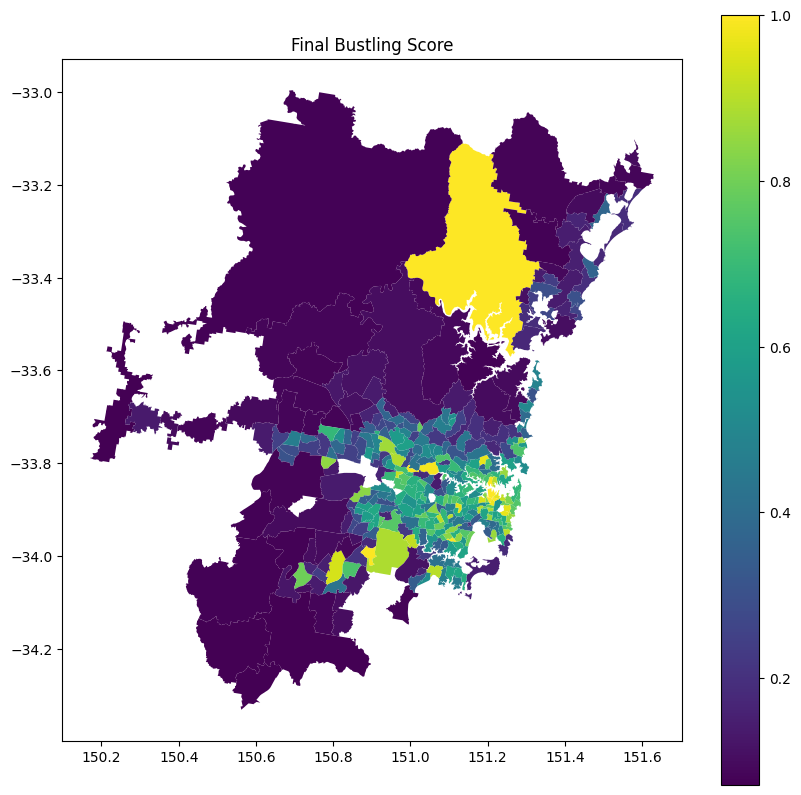

In [75]:
# Plot the final bustling score on a map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='final_bustling_score', ax=ax, legend=True, cmap='viridis')
ax.set_title('Final Bustling Score')
plt.show()

In [81]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [96]:
gdf_income = gpd.read_postgis("""SELECT sa2_metrics.sa2_code21,sa2_metrics.geom,income.median_income FROM income 
                           Right JOIN sa2_metrics on sa2_metrics.sa2_code21::numeric = income.sa2_code21::numeric;""",conn,crs=4326)

In [104]:
gdf_income['median_income'] = zscore(gdf_income['median_income'].astype(float))
gdf_income.head()

,sa2_code21,geom,median_income
0,102011028,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362...",-0.435398
1,102011029,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",-0.744850
2,102011030,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",-1.016927
3,102011031,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",-0.747020
4,102011032,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",-0.503738


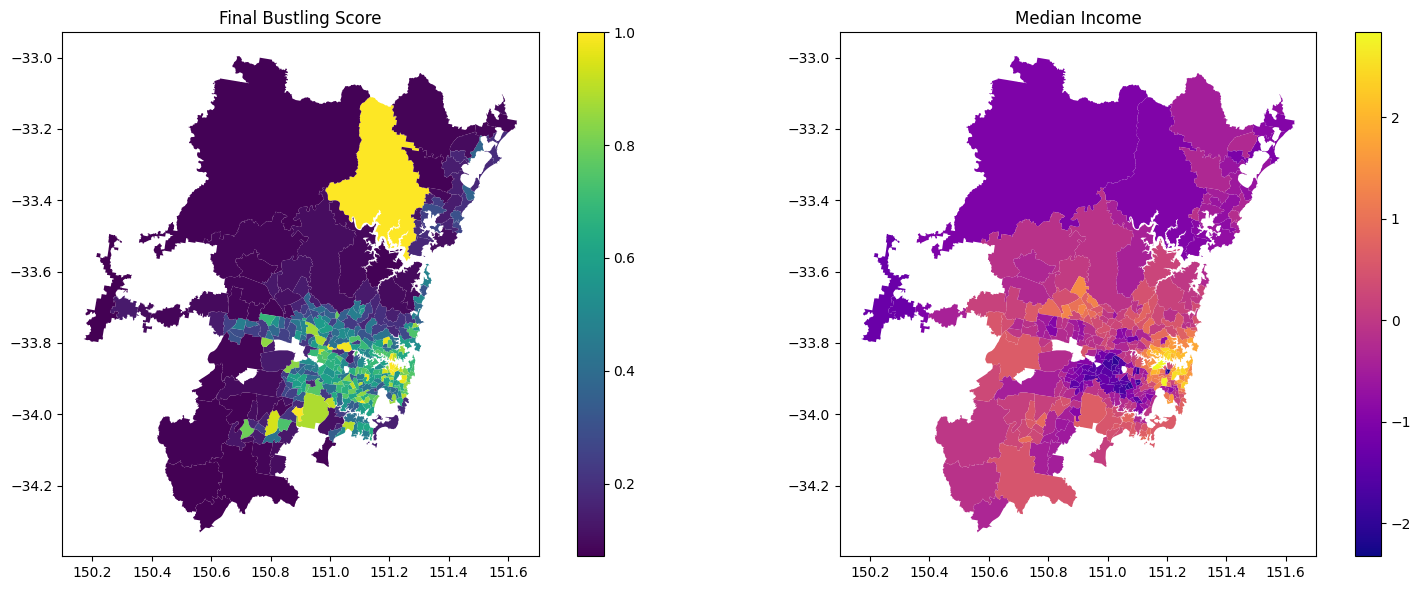

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot the final bustling score on a map
gdf.plot(column='final_bustling_score', ax=ax1, legend=True, cmap='viridis')
ax1.set_title('Final Bustling Score')

# Plot the median income on a map
gdf_income.plot(column='median_income', ax=ax2, legend=True, cmap='plasma')
ax2.set_title('Median Income')


plt.tight_layout()
plt.show()

In [106]:
# Calculate the Pearson correlation coefficient
corr, p_value = pearsonr(gdf['final_bustling_score'], gdf_income['median_income'])
print(f"Pearson correlation coefficient: {corr:.4f}")
print(f"p-value: {p_value:.4f}")

Pearson correlation coefficient: 0.0683
p-value: 0.1964


The correlation value of 0.0683 is considered low, and the high p-value suggests that the correlation is not statistically significant. This means that there is no strong linear relationship between the "final bustling score" and the median income of the regions based on the available data.

In [ ]:
conn.close()
db.dispose()